<a href="https://colab.research.google.com/github/RayBasilio123/R5/blob/master/Calcula_Eto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
import math
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib as plt
import matplotlib.pyplot as plt
# Vou precisar:

# 1 - altitude e latitude das estações
# 2 - Temp_max e Temp_min
# 3 - UR = Umidade relativa
# 4 - U2 = velocidade do vento tranformada para 2m de altura
# 5 - RAD = radiação W/m2/(1000000/86000) -> W/m2
# 6 - J = Numero de dias 









In [43]:


"""
Gera série temporal de Evapotranspiração de Referência
Referência: FAO 56 (2006)
Dados climáticos usados como entrada:
- Temperaturas (máxima, mínima e média) do ar em °C - Tmax, Tmin e Tmean
- Umidade Relativa Média - RH
- Insolação em Horas - I
- Velocidade do vento em m/s - U2
- Dia do ano - J
Dados da estação meteorológica usados como entrada:
Latitude em radianos
Altitude em metros
Constante Solar é de 0.0820  MJ m−2 min−1 
Constante de Stefan Boltzmann é de 0.000000004903  MJ m−2 dia−1
Fluxo de calor do solo (G) para o período de 1 dia ou 10 dias = 0
"""

'\nGera série temporal de Evapotranspiração de Referência\nReferência: FAO 56 (2006)\nDados climáticos usados como entrada:\n- Temperaturas (máxima, mínima e média) do ar em °C - Tmax, Tmin e Tmean\n- Umidade Relativa Média - RH\n- Insolação em Horas - I\n- Velocidade do vento em m/s - U2\n- Dia do ano - J\nDados da estação meteorológica usados como entrada:\nLatitude em radianos\nAltitude em metros\nConstante Solar é de 0.0820  MJ m−2 min−1 \nConstante de Stefan Boltzmann é de 0.000000004903  MJ m−2 dia−1\nFluxo de calor do solo (G) para o período de 1 dia ou 10 dias = 0\n'

In [44]:
#Constante Psicrometrica

def gamma(altitude):
  eve = pow(((293-0.0065*altitude)/293),5.26)
  p =101.3*eve
  gamma=p*0.000663
  return gamma


In [45]:
#Pressão de valor de saturação

# def Es(Temp_max,Temp_min):
#   es=((0.06108* math.exp((17.27*Temp_max)/(Temp_max+237.3)))+(0.06108* math.exp((17.27*Temp_min)/(Temp_min+237.3))))/2
#   return es
def Es(t):
  
   
    return 0.6108 * math.exp((17.27 * t) / (t + 237.3))
    
def Es_medio(tmin, tmax):
    
    return (Es(tmin) + Es(tmax)) / 2.0


In [46]:
#Pressão de vapor

def Ea(Temp_max,Temp_min,UR):
  ea=(UR* Es_medio(Temp_max,Temp_min))/100
  
  return ea


In [47]:
#Declividade da curva de pressão de vapor dágua da atm

def Delta(Temp_max,Temp_min):
  T = (Temp_max+Temp_min)/2
  aux_delta = 4098*pow(0.6108, (17.27 * T)/(T + 237.3) )
  delta = aux_delta/(pow((T+237.3),2))
  return aux_delta


In [48]:
def Rns(rs, albedo=0.23):  
    rns =  (1 - albedo) * rs
    return rns

In [49]:
# Radiação solar que atinge a superficie da terra

def Rs(N, Ra, Temp_max, Temp_min):

    rs = 0.16 * np.sqrt(Temp_max - Temp_min) * Ra
    return rs


# def Rs(N, n, ra, tmax, tmin):
#     """
#     Radiação Solar ( Rs ): Equação 35 (FAO 56)
#     OBS: em caso de ausência de n, será usada a Equação 50 (FAO 56)
#     :parâmetro N: duração máxima de insolação no dia [h]. Pode ser calculada pela função N.
#     :parâmetro n: Insolação [h].
#     :parâmetro Ra: extraterrestrial radiation [MJ m-2 day-1]. Calculada pela função Ra.
#     :return: radiação solar [MJ m-2 day-1]
#     """
#     if np.isnan(n):
#       rs = 0.16 * np.sqrt(tmax - tmin) * ra
#     else:
#       rs = (0.5 * n / N + 0.25) * ra
#     return rs


In [50]:
def Rso(altitude, ra):
    rso = (0.00002 * altitude + 0.75) * ra
    return rso

In [51]:
#Diferença entre a radiação de onda longa emitida e recebida 
def Rnl(Temp_max, Temp_min, rs, rso, ea, sigma):
  
    k_temp_max = Temp_max + 273.16 
    k_temp_min = Temp_min + 273.16 
    
    rnl = (sigma * ((pow(k_temp_max, 4) + pow(k_temp_min, 4)) / 2))*(0.34 - (0.14 * math.sqrt(ea)))*( 1.35 * (rs / rso) - 0.35)

    return rnl


In [52]:
#Saldo de radiação na superficie da cultura

def Rn(Rns,Rnl):
  rn=Rns-Rnl
  return rn


In [53]:
def Et_fao(rn, t, u2, es, ea, delta, gamma, G):
    a1 = (0.408 * (rn - G) * delta) + ((900 / (t + 273)) * u2 * gamma * (es - ea))
    a2 =  a1 / (delta + (gamma * (1 + 0.34 * u2)))
    return a2


In [54]:
def N_insolacao(omega):
   insol = (24.0 / math.pi) * omega
   return insol
    

In [55]:
def Dr(J):
    dr = 1 + (0.033 * math.cos((2.0 * math.pi / 365.0) * J))
    return dr

In [56]:
def Omega(latitude, declinacao_sol):
    cos_sha = -math.tan(latitude) * math.tan(declinacao_sol)
    omega = math.acos(min(max(float(cos_sha), float(-1.0)), float(1.0)))
    return omega

In [57]:
def Declinacao_sol(J):
    decli_sol = float(0.409) * math.sin(((float(2.0) * math.pi / float(365.0)) * J - float(1.39)))
    return decli_sol

In [58]:
def Ra(latitude, declinacao_sol, omega, dr, Gsc):
    tmp1 = (24.0 * 60.0) / math.pi
    tmp2 = omega * math.sin(latitude) * math.sin(declinacao_sol)
    tmp3 = math.cos(latitude) * math.cos(declinacao_sol) * math.sin(omega)
    rad = tmp1 * Gsc * dr * (tmp2 + tmp3)
    return rad

In [59]:
def media_umi(umi_max, umi_min):
  media = (umi_max + umi_min)/2
  return media

In [60]:
def Pressao_atm(altitude):
    """
    Pressão Atmosférica (P): Equação 7 (FAO 56)
    :parâmetro altitude: altitude acima do nível do mar [m]
    :return: pressão atmosférica [kPa]
    """
    tmp = (293.0 - (0.0065 * altitude)) / 293.0
    return math.pow(tmp, 5.26) * 101.3

In [61]:
url='https://raw.githubusercontent.com/RayBasilio123/R5/master/dados%20(3)'
df = pd.read_csv(url)
url='https://raw.githubusercontent.com/PatriciaLucas/Evapotranspiracao/master/variaveis_setelagoas.csv'
dl = pd.read_csv(url,delimiter=',')



In [62]:

def calcula_dia(dataset):
    """
      Calcula dia do ano e acrescenta na base de dados
      :param dataset: base de dados completa
      :return: base de dados + coluna com o dia do ano
    """
    date = dataset['Data']
    day_of_year = []
    for i in range(date.shape[0]):
      adate = datetime.strptime(date[i],"%Y-%m-%d")
      day_of_year.append(adate.timetuple().tm_yday)
    day = np.asarray(day_of_year)
    dayframe=pd.DataFrame(day,columns=['J'])
    d = [dataset,dayframe]
    dataset = pd.concat(d,axis=1)
    return dataset
    


In [63]:
df = calcula_dia(df)

In [64]:
print(" 0 = {0}".format(df.columns[0]))
print(" 1 = {0}".format(df.columns[1]))
print(" 2 = {0}".format(df.columns[2]))
print(" 3 = {0}".format(df.columns[3]))
print(" 4 = {0}".format(df.columns[4]))
print(" 5 = {0}".format(df.columns[5]))
print(" 6 = {0}".format(df.columns[6]))
print(" 7 = {0}".format(df.columns[7]))
print(" 8 = {0}".format(df.columns[8]))
print(" 9 = {0}".format(df.columns[9]))
print(" 10 = {0}".format(df.columns[10])) 

 0 = Data
 1 = vento
 2 = radiacao
 3 = temp_max
 4 = temp_min
 5 = umi_max
 6 = umi_min
 7 = umi_rel
 8 = press_atm
 9 = temp_media
 10 = J


In [65]:
print(" 0 = {0}".format(dl.columns[0]))
print(" 1 = {0}".format(dl.columns[1]))
print(" 2 = {0}".format(dl.columns[2]))
print(" 3 = {0}".format(dl.columns[3]))
print(" 4 = {0}".format(dl.columns[4]))
print(" 5 = {0}".format(dl.columns[5]))
print(" 6 = {0}".format(dl.columns[6]))
print(" 7 = {0}".format(dl.columns[7]))


 0 = Data
 1 = Tmax
 2 = Tmin
 3 = I
 4 = Tmean
 5 = UR
 6 = V
 7 = J


In [66]:
def gera_serie(dataset, latitude, altitude, Gsc, sigma, G):

    serie_eto = []
    for linha in range(len(dataset)):
        es = Es_medio(dataset.iloc[linha,3],dataset.iloc[linha,4]) #------------> Pressão do vapor de saturação
        media =  media_umi(dataset.iloc[linha, 5], dataset.iloc[linha, 6])
        ea = Ea(dataset.iloc[linha,3],dataset.iloc[linha,4],media) #--------> Pressão do vapor atual
        # print('i {}, tmin {}, tmax {}, media {}, ea {}'.format(linha,dataset.iloc[linha,3],dataset.iloc[linha,4],media,ea))
        
        delta = Delta(dataset.iloc[linha,3], dataset.iloc[linha, 4]) #----------------------> Declividade da curva de pressão do vapor
        pressao_atm = Pressao_atm(altitude) #-----------> Pressão atmosférica
        gamma_ = gamma(altitude) #------------> Constante
        declinacao_sol = Declinacao_sol(dataset.iloc[linha,10]) #----> Declinação solar
        omega = Omega(latitude, declinacao_sol) #-------> Ângulo horário pôr-do-sol
        dr = Dr(dataset.iloc[linha,10]) #----------------------------> Inverso da distância relativa da terra-sol
        ra = Ra(latitude, declinacao_sol, omega, dr, Gsc) #--> Radiação extraterrestre para períodos diários
        N = N_insolacao(omega) #------------------------> Duração máxima de insolação no dia
        rs = Rs(N, ra, dataset.iloc[linha,3], dataset.iloc[linha,4]) #---------------------> Radiação solar
        rso = Rso(altitude, ra) #-----------------------> Radiação solar de céu claro
        rns = Rns(rs, albedo=0.23) #--------------------> Radiação de onda curta líquida
        rnl = Rnl(dataset.iloc[linha,3],dataset.iloc[linha,4], rs, rso, ea, sigma) #---> Radiação de onda longa líquida
        rn = Rn(rns,rnl) #------------------------------> Radiação líquida
        serie_eto.append(Et_fao(rn, dataset.iloc[linha,9], dataset.iloc[linha,1], es, ea, delta, gamma_, G=0)) #---> Evapotranspiração
      #  (rn, t, u2, es, ea, delta, gamma, G)
        
    return serie_eto

In [67]:

latitude_graus = -19.46 #--em graus
altitude = 732.00  #--em metros
latitude = (math.pi * latitude_graus)/180
Gsc = 0.0820
sigma = 0.000000004903
G = 0
print(math.pi)

    

3.141592653589793


In [68]:
df

,Data,vento,radiacao,temp_max,temp_min,umi_max,umi_min,umi_rel,press_atm,temp_media,J
0,2018-01-01,1.196103,75.66516,29.8,20.3,92.0,40.0,75.375000,916.491667,23.595833,1
1,2018-01-02,1.386252,74.78532,29.8,19.4,92.0,49.0,71.583333,914.350000,23.912500,2
2,2018-01-03,1.260508,76.30524,30.1,18.7,93.0,47.0,74.166667,913.745833,23.760417,3
3,2018-01-04,0.972217,21.31272,22.4,18.8,93.0,85.0,91.166667,916.491667,20.397917,4
4,2018-01-05,0.910878,48.75192,28.0,19.0,93.0,58.0,85.958333,918.862500,21.172917,5
...,...,...,...,...,...,...,...,...,...,...,...
725,2019-12-27,1.849359,86.27040,29.1,19.9,83.0,40.0,60.208333,919.566667,24.000000,361
726,2019-12-28,1.444524,74.16828,28.6,19.7,88.0,44.0,65.583333,918.841667,23.247917,362
727,2019-12-29,1.162367,69.95988,29.4,18.8,90.0,40.0,72.666667,917.520833,22.433333,363
728,2019-12-30,1.594804,85.08924,29.3,18.1,84.0,32.0,61.375000,915.866667,22.852083,364


In [69]:

eto=gera_serie(df, latitude, altitude, Gsc, sigma, G)

eto


[5.405639469146857,
 5.66926106202299,
 5.8923845999017175,
 3.6331624344389706,
 5.3273150542876735,
 5.433273006703505,
 5.6788243473082245,
 5.08785921483468,
 5.236446633462288,
 5.168969772833224,
 4.9193895714204965,
 5.3358385680434175,
 5.394410319090354,
 5.302682757345574,
 5.704991663342545,
 5.825140537435305,
 5.450452305463103,
 5.463507949864796,
 5.671933441265589,
 5.336777414976892,
 5.1107226395941705,
 5.160848799534599,
 5.279645129177441,
 5.337517926391696,
 5.080078597113397,
 5.436560059060103,
 5.069838042215199,
 5.687872573825913,
 5.59099352453163,
 5.625171017163755,
 5.002085042089708,
 4.867301791713683,
 3.402349018797549,
 5.405695234520107,
 3.5763781831864327,
 3.9353946515884997,
 5.022775350374385,
 5.2429470687886,
 5.930331595496874,
 5.419963617406791,
 5.057822072969041,
 5.157936299380163,
 5.1818735770749695,
 5.002688773182737,
 4.818339433195682,
 5.083732260661669,
 5.054077266724466,
 5.035634931886778,
 5.3045278966182465,
 4.59273202915

#Graficos

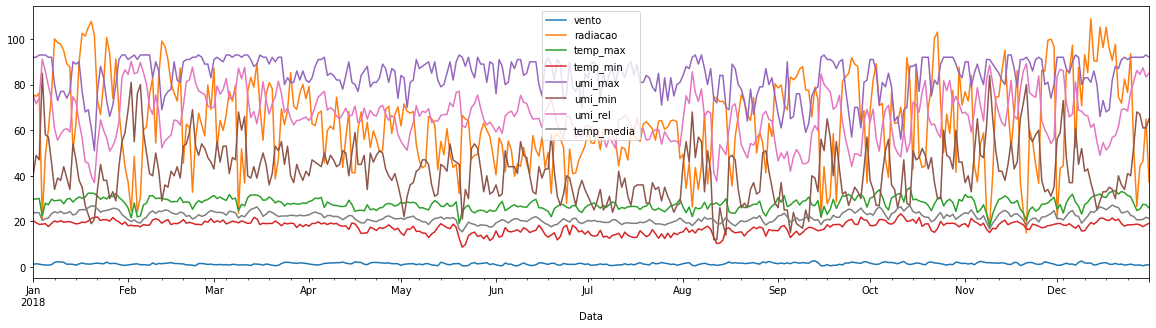

In [70]:
dataplot = df.drop(["press_atm","J"],axis=1)

dataplot.set_index('Data', inplace=True)

dataplot.index = pd.to_datetime(dataplot.index,format='%Y-%m-%d')
dataplot['2018'].plot(figsize=(20,5))

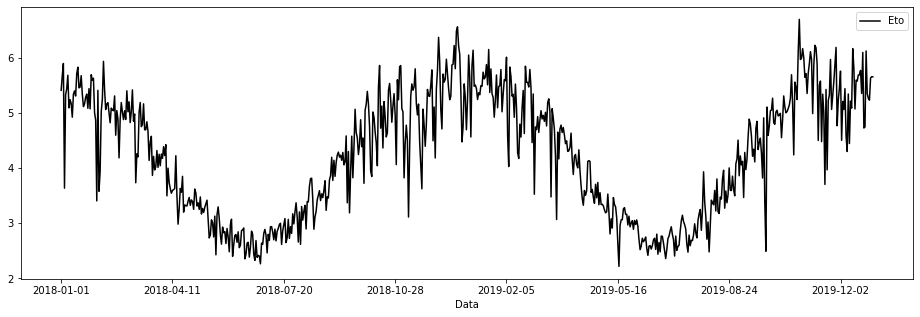

In [71]:
daf = pd.DataFrame(eto,columns=['Eto'])
daf.insert(0,'Data', df.loc[:,'Data'])
daf.set_index('Data', inplace=True)
#df.index = df.index.to_datetime('"%y-%m-%d"')
daf.plot(figsize=(16,5), color='k')
daf.to_csv('/content/sample_data/Eto')


#ANALYZING DATA

In [72]:
from statsmodels.tsa.stattools import acf, pacf
import numpy as np
import pandas as pd
import time

In [73]:
url3 = 'https://raw.githubusercontent.com/RayBasilio123/R5/master/Eto'
df_Eto = pd.read_csv(url3, header=0, parse_dates=[0], index_col=0, squeeze=True)
serie_Eto = pd.Series(df_Eto)

In [74]:
p, c = pacf(serie_Eto, alpha=0.05,nlags=365)
p2, c2 = acf(serie_Eto, alpha=0.05,nlags=365)
pd, cd = pacf((serie_Eto.values[:-1] - serie_Eto.values[1:]), alpha=0.05)
# nlags=365
p2d, c2d = acf((serie_Eto.values[:-1] - serie_Eto.values[1:]), alpha=0.05)

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


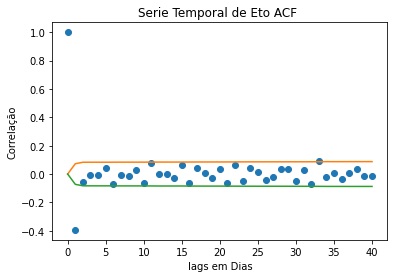

In [75]:
plt.plot(p2d,'o')
plt.plot(c2d[:,1]-p2d)
plt.plot(c2d[:,0]-p2d)
plt.title('Serie Temporal de Eto ACF ')
plt.xlabel('lags em Dias')
plt.ylabel('Correlação')
plt.show()

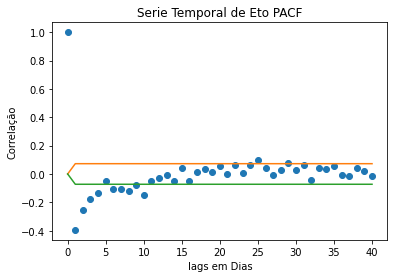

In [76]:
import matplotlib.pyplot as plt
plt.plot(pd,'o')
plt.plot(cd[:,1]-pd)
plt.plot(cd[:,0]-pd)
plt.title('Serie Temporal de Eto PACF')
plt.xlabel('lags em Dias')
plt.ylabel('Correlação')
plt.show()

In [77]:
#lcap ou ssAutoArima = low cost arima parameters or Super simple autoArima

#serie = serie temporal
#tipo_ACF_ou_PACF = acf ou pacf
#diferenciar = numero inteiro 0 ou 1
#Se você passou acf, o valor retornado é a ordem do "q"
#Se você passou pacf, o valor retornado é a ordem do "p"

def lcap (serie,difenciar,tipo_ACF_ou_PACF):
  from statsmodels.tsa.stattools import acf, pacf

  
  cont_Ordem = 0
  if difenciar == 0:
       p1, c1 = tipo_ACF_ou_PACF(serie, alpha=0.05)
       for _p,_c0,_c1 in zip(p1,c1[:,0],c1[:,1]):
          if _p > (_c1-_p) or _p < (_c0-_p):
            cont_Ordem+=1
          else:
            break
  elif difenciar == 1:
       p1, c1 = tipo_ACF_ou_PACF((serie.values[:-1] - serie.values[1:]), alpha=0.05)
       for _p,_c0,_c1 in zip(p1,c1[:,0],c1[:,1]):
          if _p > (_c1-_p) or _p < (_c0-_p):
            cont_Ordem+=1
          else:
            break
  
  else:
    print ("Difrenciacao Maxima permitida == 1 ")
  
  
  return cont_Ordem

In [78]:
#ssAutoArima = Super simple autoArima

def ssArima(serie,d):
  start = time.time()
  q=lcap(serie,d,acf)
  p=lcap(serie,d,pacf)
  t = time.time() - start

  return print("Arimalcap",(p,d,q),t)

#Parametros Arima

In [79]:
ssArima(serie_Eto,0)

Arimalcap (6, 0, 41) 0.026296377182006836


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


In [80]:
ssArima(serie_Eto,1)

Arimalcap (5, 1, 2) 0.023749589920043945


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
